# Classical ML Techniques


In [1]:
from glob import glob
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

files = sorted(glob('/workspace/nifty/NIFTY/*.csv'))


def mark_events(
        series: pd.Series,
        ref_frame: int = 5
) -> pd.DataFrame:
    sell = (
        series == series.shift(
            -ref_frame
        ).rolling(
            2 * ref_frame
        ).max()
    )
    buy = (
        series == series.shift(
            -ref_frame
        ).rolling(
            2 * ref_frame
        ).min()
    )
    return sell, buy


def read_csv(file):
    df = pd.read_csv(file, header=0)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['date'] = df['datetime'].dt.date
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    # df['minute_15'] = (df['datetime'].dt.minute//15)*15
    df = df[df.hour.isin(list(range(9, 16)))].reset_index(drop=True)
    # df.set_index('datetime', inplace=True)

    return df[['datetime', 'open', 'high', 'low', 'close', 'date', 'hour', 'minute']]


dfs = pd.concat([read_csv(file)
                for file in tqdm(files, leave=False, desc='Reading CSVs')])
dfs.head()

Reading CSVs:   0%|          | 0/2225 [00:00<?, ?it/s]

,datetime,open,high,low,close,date,hour,minute
0,2015-01-01 09:14:00,8272.80,8272.80,8272.80,8272.80,2015-01-01,9,14
1,2015-01-01 09:15:00,8272.80,8272.80,8272.80,8272.80,2015-01-01,9,15
2,2015-01-01 09:16:00,8253.15,8253.15,8253.15,8253.15,2015-01-01,9,16
3,2015-01-01 09:17:00,8254.15,8254.15,8254.15,8254.15,2015-01-01,9,17
4,2015-01-01 09:18:00,8261.15,8261.15,8261.15,8261.15,2015-01-01,9,18


Scaling:   0%|          | 0/2219 [00:00<?, ?it/s]

0.00   -3.570495
0.05   -1.984521
0.25   -0.986064
0.50    0.062885
0.75    1.035579
0.95    1.928045
1.00    3.571650
Name: sClose, dtype: float64


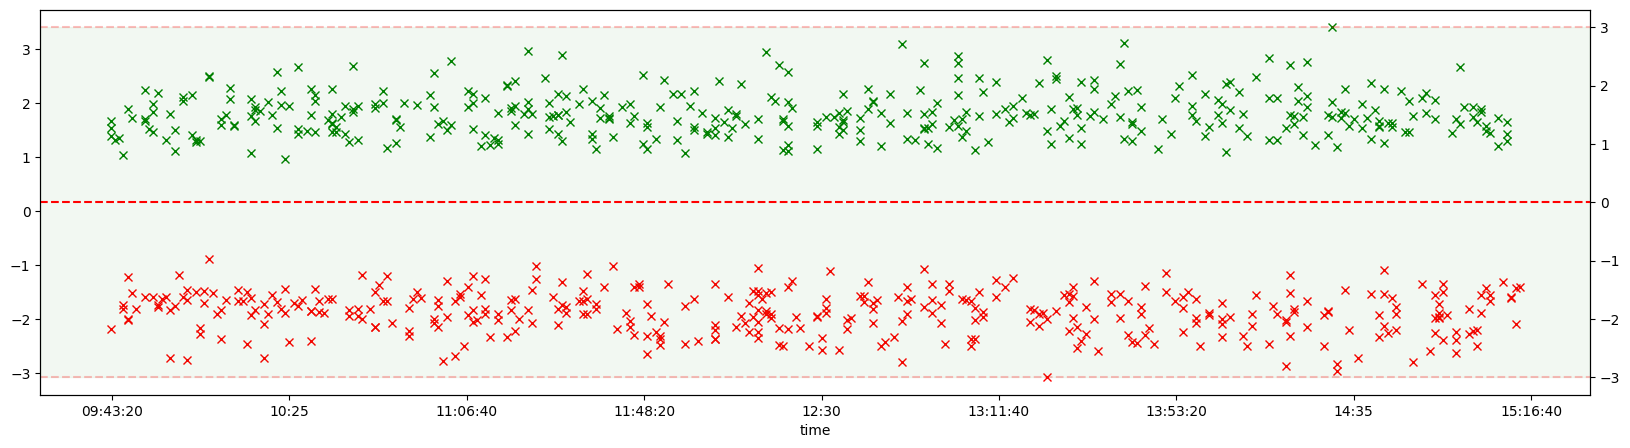

In [2]:
sdfs = []
window = 15
event_window = 15
for date, group in tqdm(dfs.groupby('date'), leave=False, desc='Scaling'):
    group['close_mean'] = group.close.rolling(window).mean()
    group['close_std'] = group.close.rolling(window).std()
    group['sClose'] = (group.close - group.close_mean) / group.close_std
    group['peak'], group['dip'] = mark_events(group.close, event_window)
    group.dropna(inplace=True)
    sdfs.append(group)

scaling_df = pd.concat(sdfs)

# scaling_df.shape
print(scaling_df.sClose.quantile([0, .05, .25, .5, .75, .95, 1]))

dates = np.random.choice(scaling_df.date.unique(), 50)

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True)
tax = ax.twinx()

for date_ in dates[:]:
    sdf = scaling_df[scaling_df['date'] == date_].reset_index(drop=True).copy()
    sdf['time'] = sdf.datetime.dt.time
    sdf.set_index('time', inplace=True)
    # sdf.sClose.apply(lambda x: x if np.abs(x) < 4 else None).plot(
    #     ax=tax, color='r', alpha=.05, marker='x', lw=None)
    sdf.sClose[sdf.peak].plot(ax=ax, color='g', marker='x', ls='None')
    sdf.sClose[sdf.dip].plot(ax=ax, color='r', marker='x', ls='None')


tax.axhline(0, color='r', linestyle='--')
tax.axhspan(-3, 3, color='g', alpha=.05)
tax.axhline(-3, color='r', linestyle='--', alpha=.25)
tax.axhline(3, color='r', linestyle='--', alpha=.25)

plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier
# , KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

train_dates, test_dates = train_test_split(
    scaling_df.date.unique(),
    test_size=.2,
    shuffle=True
)

train_df = scaling_df[scaling_df.date.isin(train_dates)].copy()

test_df = scaling_df[scaling_df.date.isin(test_dates)].copy()


sample_size = train_df['peak'].value_counts().max()

sell_train_df = pd.concat(
    [
        train_df[train_df.peak].sample(sample_size, replace=True),
        train_df[~train_df.peak].sample(sample_size, replace=True),
    ]
)

buy_train_df = pd.concat(
    [
        train_df[train_df.dip].sample(sample_size, replace=True),
        train_df[~train_df.dip].sample(sample_size, replace=True),
    ]
)


clf_sell = RandomForestClassifier(n_estimators=100, random_state=0)
clf_buy = RandomForestClassifier(n_estimators=100, random_state=0)

# clf_sell.fit(train_df[['sClose']], train_df['peak'])
# clf_buy.fit(train_df[['sClose']], train_df['dip'])

# clf_sell = KNeighborsClassifier(n_neighbors=100)
# clf_buy = KNeighborsClassifier(n_neighbors=100)

clf_sell.fit(sell_train_df[['sClose']], sell_train_df['peak'])
clf_buy.fit(buy_train_df[['sClose']], buy_train_df['dip'])

test_df['buy_pred'] = clf_buy.predict(test_df[['sClose']])
test_df['sell_pred'] = clf_sell.predict(test_df[['sClose']])

print('buy_classifier')
print(accuracy_score(test_df['dip'], test_df['buy_pred']))
print(confusion_matrix(test_df['dip'], test_df['buy_pred']))
print(classification_report(test_df['dip'], test_df['buy_pred']))

print('sell_classifier')
print(accuracy_score(test_df['peak'], test_df['sell_pred']))
print(confusion_matrix(test_df['peak'], test_df['sell_pred']))
print(classification_report(test_df['peak'], test_df['sell_pred']))

buy_classifier
0.9546634387401103
[[152387   4534]
 [  2732    615]]
              precision    recall  f1-score   support

       False       0.98      0.97      0.98    156921
        True       0.12      0.18      0.14      3347

    accuracy                           0.95    160268
   macro avg       0.55      0.58      0.56    160268
weighted avg       0.96      0.95      0.96    160268

sell_classifier
0.9548943020440762
[[152503   4454]
 [  2775    536]]
              precision    recall  f1-score   support

       False       0.98      0.97      0.98    156957
        True       0.11      0.16      0.13      3311

    accuracy                           0.95    160268
   macro avg       0.54      0.57      0.55    160268
weighted avg       0.96      0.95      0.96    160268



In [6]:

train_df['buy_pred'] = clf_buy.predict(train_df[['sClose']])
train_df['sell_pred'] = clf_sell.predict(train_df[['sClose']])

print('buy_classifier')
print(accuracy_score(train_df['dip'], train_df['buy_pred']))
print(confusion_matrix(train_df['dip'], train_df['buy_pred']))
print(classification_report(train_df['dip'], train_df['buy_pred']))

print('sell_classifier')
print(accuracy_score(train_df['peak'], train_df['sell_pred']))
print(confusion_matrix(train_df['peak'], train_df['sell_pred']))
print(classification_report(train_df['peak'], train_df['sell_pred']))

buy_classifier
0.8320338726938793
[[520905 107512]
 [   311  13205]]
              precision    recall  f1-score   support

       False       1.00      0.83      0.91    628417
        True       0.11      0.98      0.20     13516

    accuracy                           0.83    641933
   macro avg       0.55      0.90      0.55    641933
weighted avg       0.98      0.83      0.89    641933

sell_classifier
0.821168252761581
[[514079 114429]
 [   369  13056]]
              precision    recall  f1-score   support

       False       1.00      0.82      0.90    628508
        True       0.10      0.97      0.19     13425

    accuracy                           0.82    641933
   macro avg       0.55      0.90      0.54    641933
weighted avg       0.98      0.82      0.88    641933

